<div class="alert alert-block alert-info">
    
## Libaries
</div>

In [1]:
options(warn = -1)

In [2]:
library(caret)
library(tidyverse)
library(ggplot2)
library(GGally)
library(leaps)
library(lubridate)
library(boot)
library(DAAG)
library(randomForest)
library(gridExtra) 
library(reshape2)

Loading required package: ggplot2

Loading required package: lattice

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::lift()   masks caret::lift()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: 'boot'


The following object is masked from 'package:lattice':

    melanoma


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:dplyr':

    combine


The following object is maske

<div class="alert alert-block alert-info">
    
## Table of Contents

</div>

[1. Exploratory Data Analysis](#EDA) <br>
[2. Random forest modeling](#rf) <br>
[3. Final model selection](#select) <br>
[4. File preparation](#submit) <br>

<div class="alert alert-block alert-success">
    
## Exploratory Data Analysis  <a class="anchor" name="EDA"></a>

Load all datasets.

In [3]:
train_raw <- read.csv(file.path("A1_petrol_price_labeled.csv"),sep=",", stringsAsFactors = TRUE)
X_val <- read.csv(file.path("A1_petrol_price_kaggle.csv"),sep=",", stringsAsFactors = TRUE)
X_test <- read.csv(file.path("A1_petrol_price_submission.csv"),sep=",", stringsAsFactors = TRUE)

Next, extract extra features date, year, month, day, hour, minuet and second from date_time column.

In [4]:
# extract time data from dataset ‘A1_petrol_price_labeled.csv’
train_raw <- train_raw  %>%
    mutate(self_service = self_service) %>%
        mutate(
            date = date(date_time),      
            year = year(date_time),       
            month = month(date_time),     
            day =  day(date_time),         
            hour = hour(date_time),       
            minute = minute(date_time),   
            second = second(date_time))

In [5]:
# extract time data from dataset ‘A1_petrol_price_kaggle.csv
X_val <- X_val  %>% 
    mutate(self_service = self_service) %>%
        mutate(
            date = date(date_time),      
            year = year(date_time),       
            month = month(date_time),     
            day =  day(date_time),         
            hour = hour(date_time),       
            minute = minute(date_time),   
            second = second(date_time))

In [6]:
# extract time data from dataset A1_petrol_price_submission.csv
X_test <- X_test  %>% 
    mutate(self_service = self_service) %>%
        mutate(
            date = date(date_time),      
            year = year(date_time),       
            month = month(date_time),     
            day =  day(date_time),         
            hour = hour(date_time),       
            minute = minute(date_time),   
            second = second(date_time))


1. In the datasets, all features have similar distributions, excluding month.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


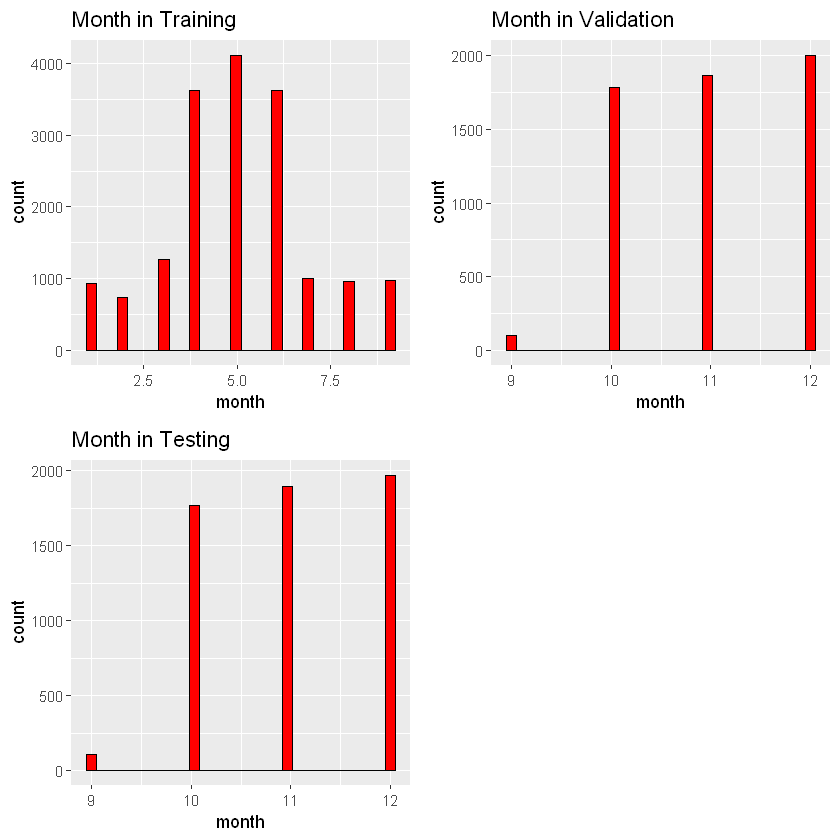

In [7]:
plt1 <- train_raw  %>% ggplot(aes(x= month)) +
    geom_histogram(color = I('black'), fill = "red") + 
    ggtitle("Month in Training")

plt2 <- X_val  %>% ggplot(aes(x= month)) +
    geom_histogram(color = I('black'), fill = "red") + 
    ggtitle("Month in Validation")

plt3 <- X_test  %>% ggplot(aes(x= month)) +
    geom_histogram(color = I('black'), fill = "red") + 
    ggtitle("Month in Testing")

grid.arrange(plt1, plt2, plt3, ncol= 2)

2. When plotting training features against price, we can see that there were no linear relationships between them. Hence, the plots suggest that a linear model might not be sufficient for describing price.

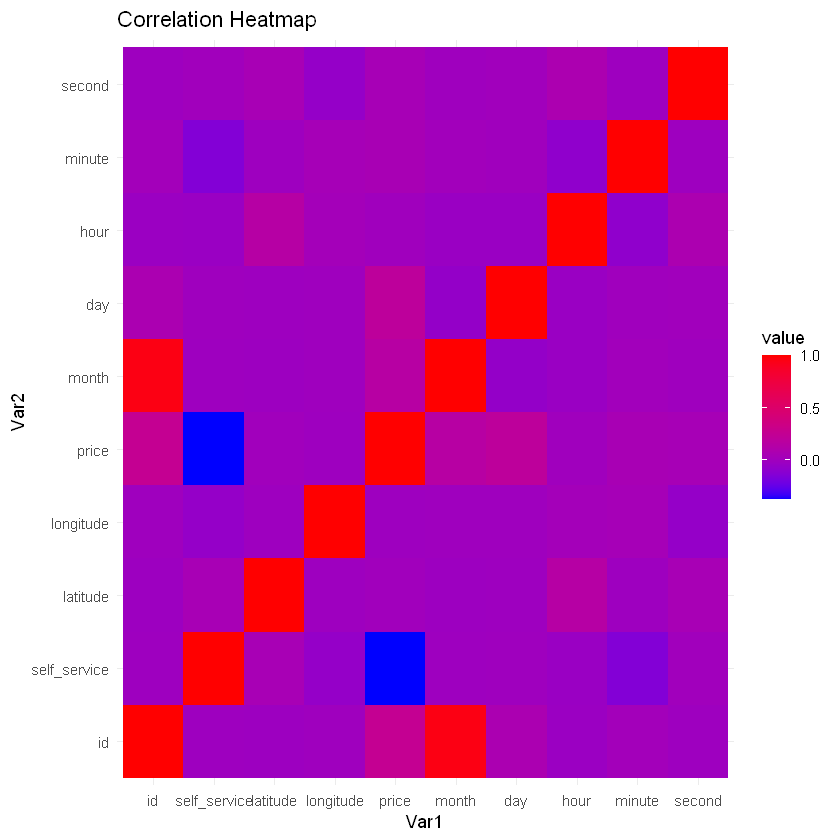

In [8]:
# poting correlation heatmap
numeric_columns <- train_raw[, sapply(train_raw, is.numeric)]
numeric_columns <- numeric_columns  %>%  select(-year)
cor_melt <- melt(cor(numeric_columns))
ggplot(cor_melt, aes(Var1, Var2, fill = value)) +
  geom_tile() +
  scale_fill_gradient(low = "blue", high = "red") +
  labs(title = "Correlation Heatmap") +
  theme_minimal()

3. Most of the activities in the training set happened during April to June as below. Which might indicate a potential seasonality in data.

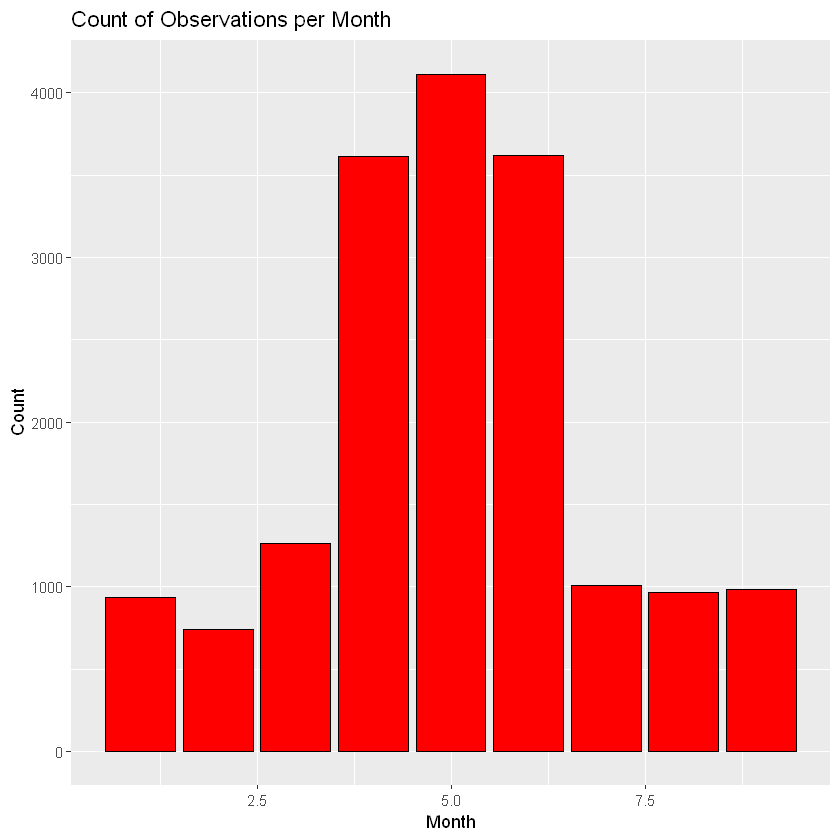

In [9]:
month_counts <- train_raw %>%
  group_by(month) %>%
  count()

ggplot(month_counts, aes(x = month, y = n)) +
  geom_bar(stat = "identity", fill= "red", color = I('black')) +
  labs(x = "Month", y = "Count") +
  ggtitle("Count of Observations per Month")

4. When plotting month and day, we can see that they revealed some time relavant patterns.

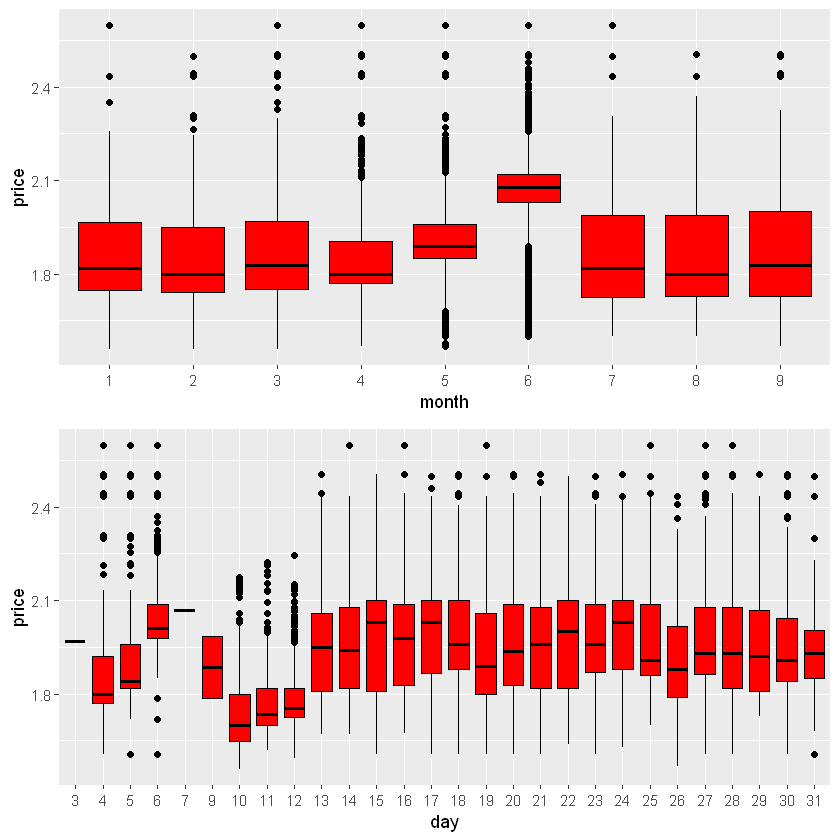

In [10]:
plt1 <- train_raw %>% 
        mutate(month = factor(month)) %>% 
        ggplot(aes(month, price))+
        geom_boxplot(fill= "red", color = I('black'))

plt2 <- train_raw %>% 
        mutate(day = factor(day)) %>% 
        ggplot(aes(day, price))+
        geom_boxplot(fill= "red", color = I('black'))

grid.arrange(plt1, plt2, nrow= 2)

5. The histogram of companies and managers demonstrates that they have different levels of activity within datasets, which might have an impact on price negotiation.

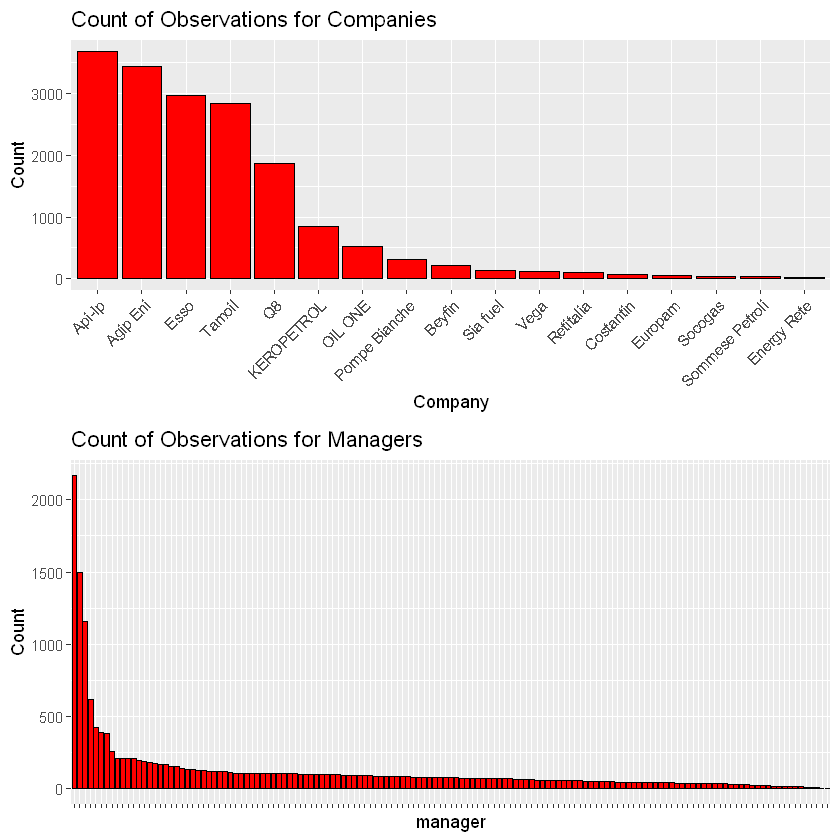

In [11]:
company_counts <- train_raw %>%
  group_by(company) %>%
  count()  %>% arrange(desc(n))

plt1 <- ggplot(company_counts, aes(x = reorder(company, -n), y = n)) +
  geom_bar(stat = "identity", fill = "red", color = "black") +
  labs(x = "Company", y = "Count") +
  ggtitle("Count of Observations for Companies") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

manager_counts <- train_raw %>%
  group_by(manager) %>%
  count()  %>% arrange(desc(n))

plt2 <- ggplot(manager_counts, aes(x = reorder(manager, -n), y = n)) +
  geom_bar(stat = "identity", fill = "red", color = "black") +
  labs(x = "manager", y = "Count") +
  ggtitle("Count of Observations for Managers") +
  theme(axis.text.x = element_blank())


grid.arrange(plt1, plt2, nrow= 2)

6. Box plots of station_category and self_service clearly indicate effect on price.

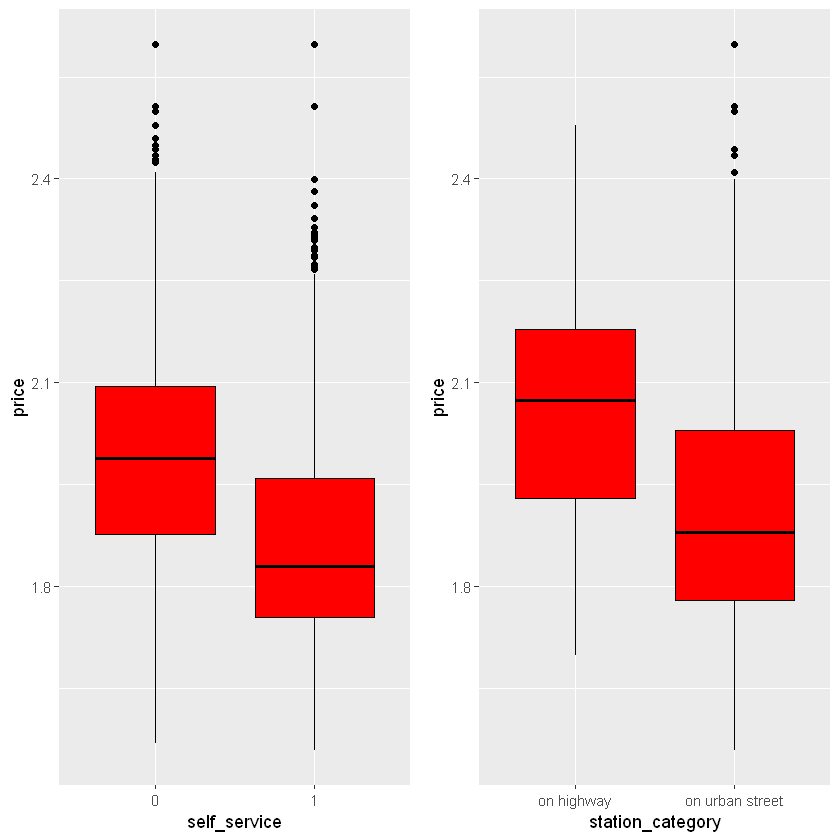

In [12]:
plt1 <- train_raw %>% 
        mutate(self_service = factor(self_service)) %>% 
        ggplot(aes(self_service, price))+
        geom_boxplot(fill= "red", color = I('black'))

plt2 <- train_raw %>% 
        mutate(station_category = factor(station_category)) %>% 
        ggplot(aes(station_category, price))+
        geom_boxplot(fill= "red", color = I('black'))

grid.arrange(plt1, plt2, nrow= 1)

<div class="alert alert-block alert-success">
    
## Random forest modeling  <a class="anchor" name="rf"></a>

Reloading data

In [3]:
train_raw <- read.csv(file.path("A1_petrol_price_labeled.csv"),sep=",", stringsAsFactors = TRUE)
X_val <- read.csv(file.path("A1_petrol_price_kaggle.csv"),sep=",", stringsAsFactors = TRUE)
X_test <- read.csv(file.path("A1_petrol_price_submission.csv"),sep=",", stringsAsFactors = TRUE)

First, we assume that petro prices is seasonal data which might follow some time series patterns, hecen we extracted extra features from date_time which are date, day, hour, minuet, week_day and transform self_service from integer to factor.

In [4]:
# change self_service from int to factor
train_raw <- train_raw  %>% 
mutate(self_service = factor(self_service)) %>%
mutate(date = date(date_time),                
    day =  day(date_time),         
    hour = hour(date_time),
    minute = minute(date_time),
    week_day = weekdays(date)) %>% 
select(-c(id, date_time))

# val set
X_val <- X_val %>% 
  mutate(self_service = factor(self_service)) %>%
  mutate(date = date(date_time),                 
         day = day(date_time),         
         hour = hour(date_time),
         minute = minute(date_time),
         week_day = weekdays(date)) %>% 
select(-date_time)

# test set
X_test <- X_test %>% 
  mutate(self_service = factor(self_service)) %>%
  mutate(date = date(date_time),                
         day = day(date_time),         
         hour = hour(date_time),
         minute = minute(date_time),
         week_day = weekdays(date)) %>% 
select(-c(date_time))

Actually, randomforest can handdle factor type data. However, when it will be error when factors have level more than 53 levels. So encoding categorical data is required for **company, manager, station_name**. The code from template also provide varince filtering, which will filter out near zero varince which will not contribute to the modeling process.

In [5]:
all.dummies <- dummyVars(~company + manager + station_name, data = train_raw)
all.binary_var <- predict(all.dummies, newdata = train_raw) # convert to binary
nzv.stat <- nearZeroVar(all.binary_var, saveMetrics=T) # check for near zero variance
all.nzv <- nearZeroVar(all.binary_var, freqCut = 1000) 

In [6]:
nzv.stat[order(nzv.stat$freqRatio, decreasing=T),] 

,freqRatio,percentUnique,zeroVar,nzv
,<dbl>,<dbl>,<lgl>,<lgl>
manager.manager_126,8621.5000,0.01159756,FALSE,TRUE
manager.manager_140,8621.5000,0.01159756,FALSE,TRUE
manager.manager_127,2873.1667,0.01159756,FALSE,TRUE
station_name.station_197,2873.1667,0.01159756,FALSE,TRUE
station_name.station_85,2873.1667,0.01159756,FALSE,TRUE
manager.manager_135,2154.6250,0.01159756,FALSE,TRUE
station_name.station_204,2154.6250,0.01159756,FALSE,TRUE
station_name.station_42,1723.5000,0.01159756,FALSE,TRUE
manager.manager_137,1566.7273,0.01159756,FALSE,TRUE


In [7]:
all.binary_var <- all.binary_var[, -all.nzv]
all.binary_var <- as.data.frame(all.binary_var)
df_binary_factor <- data.frame(lapply(all.binary_var, factor))

In [8]:
df_original_vars <- select(train_raw, self_service, station_category, latitude, longitude, price, date, day, hour, minute, week_day)
training_data <- cbind(df_binary_factor,df_original_vars)

In [9]:
#Create a test set with the binary variables identical to the training dataset.
test.binary_var <- predict(all.dummies, newdata = X_val)
test.binary_var <- test.binary_var[, -all.nzv]
test.binary_var <- as.data.frame(test.binary_var)
test_binary_var <- data.frame(lapply(test.binary_var, factor))
test_original_vars <- select(X_val, self_service, station_category, latitude, longitude, price, date, day, hour, minute, week_day)
val_data <- cbind(test_binary_var,test_original_vars)

In [10]:
#Create a test set with the binary variables identical to the training dataset.
test.binary_var <- predict(all.dummies, newdata = X_test)
test.binary_var <- test.binary_var[, -all.nzv]
test.binary_var <- as.data.frame(test.binary_var)
test_binary_var <- data.frame(lapply(test.binary_var, factor))
test_original_vars <- select(X_test, self_service, station_category, latitude, longitude, price, date, day, hour, minute, week_day)
test_data <- cbind(test_binary_var,test_original_vars)

### model development

Random forest model development steps will be as follow:
1. First, we will train full model and use it as base to do further imporvment.
2. Using different subset of important variables to rettain the model.
3. Tuning mtry parameter.
4. Tuning ntree parameter.
5. Training final model with the best parameters.

Model evaluation, normally we will use either cross validation to estimate generalised error or train test split. However, cross validation is computationally expensive. Hence, for features selection, I will use train test split method by using labelled data as training data and kaggle validation data as test data.

**Training full model**
Train model using all features.

In [21]:
set.seed(1)
rf_model <- randomForest(price ~ ., data = training_data, ntree = 100, mtry = sqrt(ncol(training_data) - 1))

**Important features**

Next, we will use **importance** to find most impotant features. The importance function will find out the most informative features.

In [22]:
feature_importance <- importance(rf_model)
importance_df <- data.frame(Feature = rownames(feature_importance),
                            Importance = feature_importance[, 1])

In [23]:
# find the features in decreasing orders of importance
# importance_df[order(importance_df$Importance, decreasing = TRUE), ]
importance_df[order(importance_df$Importance, decreasing = TRUE), ][1:10,]

,Feature,Importance
,<chr>,<dbl>
date,date,74.505274
day,day,72.140652
self_service,self_service,45.782627
latitude,latitude,7.962509
hour,hour,7.885132
company.Agip.Eni,company.Agip.Eni,6.878203
week_day,week_day,6.859066
minute,minute,6.190987
longitude,longitude,5.467282


Ploting importance of each variable. From the plot, we can see that features after top 20 showing insignificant impact RSS reduction.

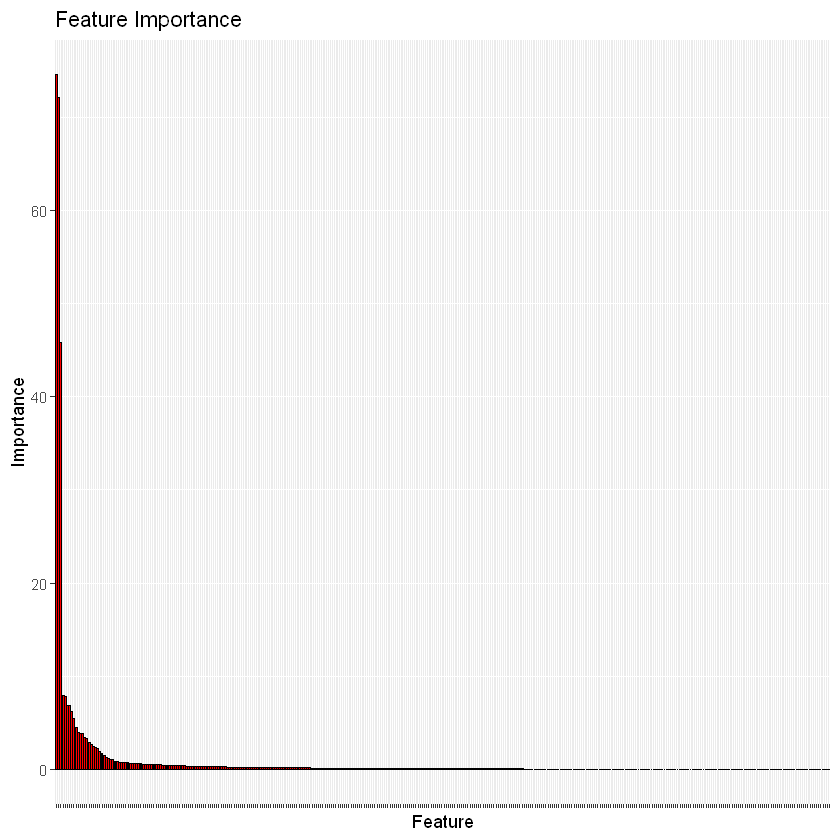

In [24]:
importance_df %>%
  ggplot(aes(x = reorder(Feature, -Importance), y = Importance)) +
  geom_col(fill = "red", color = "black") +
  labs(x = "Feature", y = "Importance") +
  ggtitle("Feature Importance") +
  theme(axis.text.x = element_blank()) 


Hence, we choose to train model with top20, 10, 8, 7, and 6 repectively to see if there is an impact on RMSE.

In [25]:
# models for differnt top features
num_top <- c(20, 10, 8, 7, 6)
top_model_list <- list()

for (num in num_top){
    train_top_data <- NULL  # initialize train_top_data as NULL
    top_feature <- importance_df[order(importance_df$Importance, decreasing = TRUE),][, 1][1:num]
    train_top_data <- training_data %>% select(top_feature, price)
    
    rf_model <- randomForest(price ~ .,
                                  data = train_top_data,
                                  ntree = 100, 
                                  mtry = sqrt(ncol(train_top_data) - 1))
    
    top_model_list[[as.character(num)]] <- rf_model 
}

From Kagglem, recevied RMSE score as follow:

    * Full model, 0.19902
    * Top20, 0.15918
    * Top10, 0.13533
    * Top8, 0.12014
    * Top7, 0.10183
    * Top6, 0.14368

Ideally, we should do models selection by doing cross validation, however, wait time for training is incredible long. Hence, we will use Kaggle validation data as hold-out dataset and use Kaggle RMSE as measurement. We finally select the top 7 features, because the model has balance between performance and complxity.

**mtry tuning**

mtry is a number that random forest use for randomly choosing when constructing trees. The right number of mtry will lead to the model performance, hence in this section we will use grid search to find the best ntree number. In addition, we will use the built-in cross validation from caret to find the best mtry.

In [26]:
top7_features <- importance_df[order(importance_df$Importance, decreasing = TRUE),][, 1][1:7]

In [27]:
top7_features

[1] "date"             "day"              "self_service"     "latitude"        
[5] "hour"             "company.Agip.Eni" "week_day"

In [11]:
top7_features <- c('date','day','self_service','latitude','hour','company.Agip.Eni','week_day')

In [12]:
# choose top 7 features
training_data <- training_data %>% select(top7_features, price)

Random Forest 

17245 samples
    7 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 15522, 15520, 15521, 15519, 15520, 15522, ... 
Resampling results across tuning parameters:

  mtry  RMSE        Rsquared   MAE       
  1     0.13732612  0.6197818  0.11073558
  2     0.09521312  0.7561300  0.06857639
  3     0.07958917  0.7933642  0.05037286
  4     0.07523749  0.8080648  0.04498497
  5     0.07256335  0.8203852  0.04220882
  6     0.07072296  0.8290921  0.04004167
  7     0.06902388  0.8371526  0.03813520

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 7.


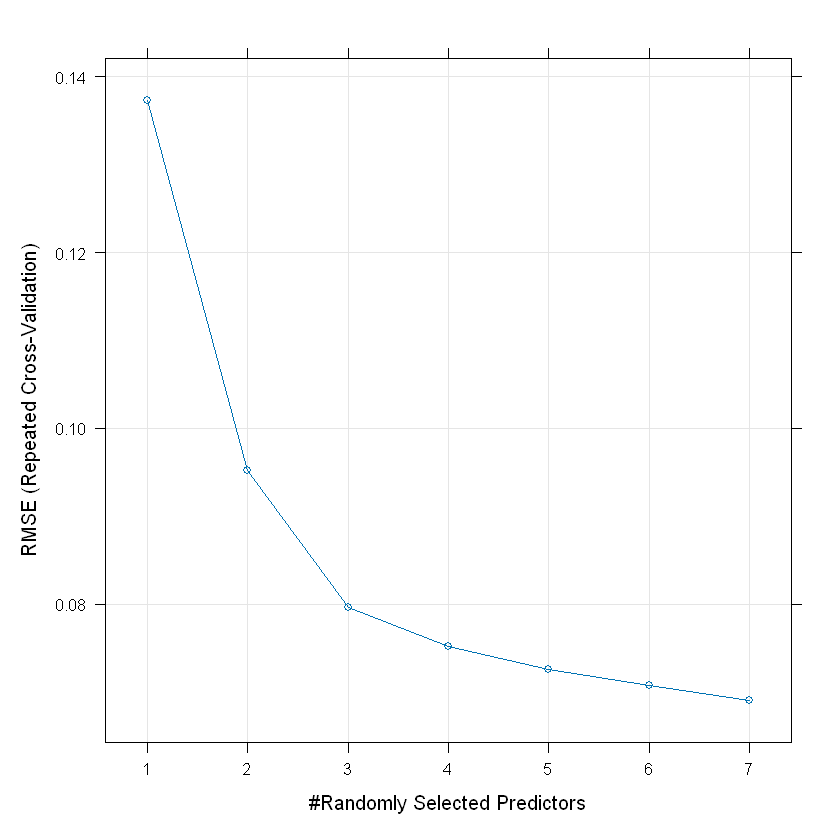

In [29]:
# fine tune mtry
control <- trainControl(method="repeatedcv", number=10, search="grid")

set.seed(1)
tunegrid <- expand.grid(.mtry=c(1:7))
rf_gridsearch <- train(price~., data=training_data, method="rf", metric= "RMSE", tuneGrid=tunegrid, trControl=control, ntree=100)
print(rf_gridsearch)
plot(rf_gridsearch)

From the plot, we can clearly see that when mtry is 7(bagging case) will provide the least average RMSE error. Next we will retrain model using top 7 features and mtry 7 and see the result on Kaggle.

In [30]:
# retain model
rf_model_top_mtry <- randomForest(price ~ ., data = training_data, ntree = 100, mtry = 7)

In [31]:
rf_model_top_mtry


Call:
 randomForest(formula = price ~ ., data = training_data, ntree = 100,      mtry = 7) 
               Type of random forest: regression
                     Number of trees: 100
No. of variables tried at each split: 7

          Mean of squared residuals: 0.003764489
                    % Var explained: 87.12

From RMSE on Kaggle, we can see that there is an improvement on model after using mtry = 7 which is scored 0.09432.

**ntree tuning**

In this section, we will use the same built-in function to search for the best ntree. Considering on training time, we will use only small list of ntree to see the effect of ntree.

In [15]:
# fine tune tree
control <- trainControl(method = 'repeatedcv',
                        number = 10,
                        search = 'grid')


tunegrid <- expand.grid(.mtry = c(7, 7, 7, 7, 7, 7))
model_list <- list()

# Felix: add 500 and 600
for (ntree in c(50, 100, 150, 200, 250, 300)){
  set.seed(1)
  rf <- train(price~.,
               data = training_data,
               method = 'rf',
               metric = 'RMSE',
               tuneGrid = tunegrid,
               trControl = control,
               ntree = ntree)
  key <- toString(ntree)
  model_list[[key]] <- rf
}

In [16]:
print(model_list)

$`50`
Random Forest 

17245 samples
    7 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 15522, 15520, 15521, 15519, 15520, 15522, ... 
Resampling results:

  RMSE        Rsquared   MAE       
  0.06913914  0.8365457  0.03829974

Tuning parameter 'mtry' was held constant at a value of 7

$`100`
Random Forest 

17245 samples
    7 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 15522, 15520, 15521, 15519, 15520, 15522, ... 
Resampling results:

  RMSE        Rsquared   MAE      
  0.06881356  0.8381347  0.0379738

Tuning parameter 'mtry' was held constant at a value of 7

$`150`
Random Forest 

17245 samples
    7 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 15522, 15520, 15521, 15519, 15520, 15522, ... 
Resampling results:

  RMSE        Rsquared   MAE       
  0.06875537  0.8384126  0.03792256



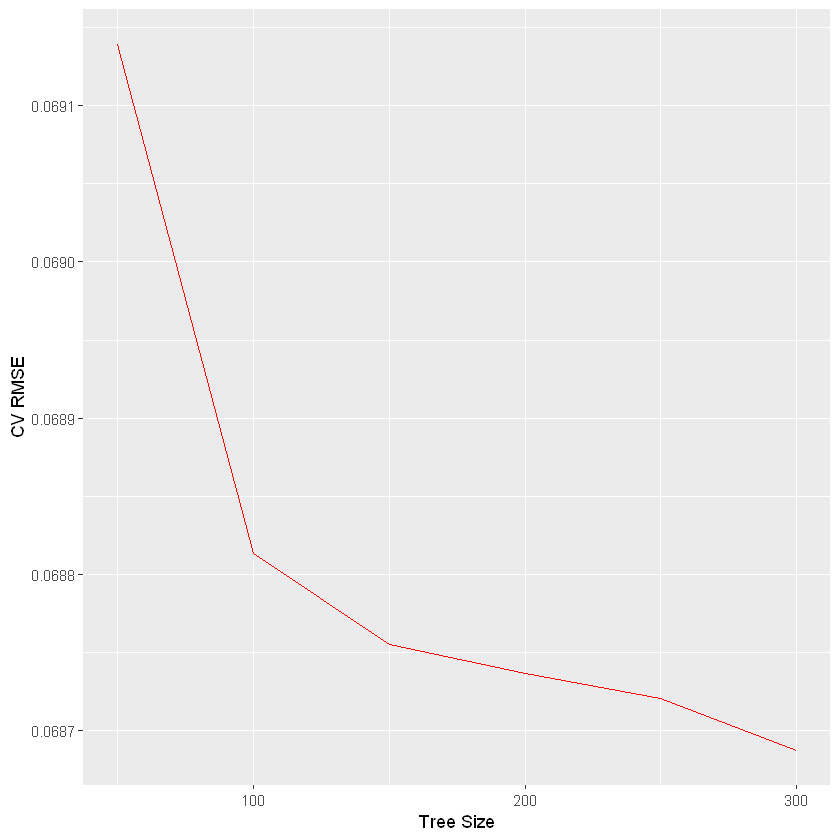

In [17]:
tree_size <- seq(50, 300, by = 50)
cv_RMSE <- c(0.06913914, 0.06881356, 0.06875537, 0.06873673,  0.06872036, 0.06868757 )
 
tree_cv <- data.frame(Tree_Size = tree_size, CV_RMSE = cv_RMSE)

tree_cv %>% 
  ggplot(aes(x = Tree_Size, y = CV_RMSE)) +
  geom_line(color= "red") +
  labs(x = "Tree Size", y = "CV RMSE")

As, we can see from the plot that at ntree number is 300 provide the least cross-validation RMSE. Hence, we will choose ntree 300 as the final number of ntree.

**Final Random Forest model**

Finally, we will combine tuned mtry and ntree to our final model. After testing on Kaggle, the performance improved slightly, 0.09348.

In [19]:
set.seed(1)
rf_final <- randomForest(price~., data= training_data, ntree= 300, mtry= 7)

**Corss validation**

To see tha generalised error of final random forest model.

In [18]:
# fine tune mtry
control <- trainControl(method="cv", number=5, search="grid")

set.seed(1)
tunegrid <- expand.grid(.mtry = c(7, 7, 7, 7, 7, 7))
rf_gridsearch <- train(price~., data=training_data, method="rf", metric= "RMSE", tuneGrid=tunegrid, trControl=control, ntree=200)
print(rf_gridsearch)

Random Forest 

17245 samples
    7 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 13797, 13796, 13797, 13795, 13795 
Resampling results:

  RMSE        Rsquared   MAE       
  0.06943559  0.8348853  0.03864595

Tuning parameter 'mtry' was held constant at a value of 7


ERROR: Error in plot.train(rf_gridsearch): There are no tuning parameters with more than 1 value.


**The final random forest model has an average RMSE of 5 fold coss validation 0.06943559.**

<div class="alert alert-block alert-success">
    
## Model Selection  <a class="anchor" name="select"></a>

In [13]:
set.seed(1)
rf_final <- randomForest(price~., data= training_data, ntree= 300, mtry= 7)

<div class="alert alert-block alert-success">
    
## Write Prediction File  <a class="anchor" name="submit"></a>

**Prepare file for submission**

In [14]:
test_data <-  test_data %>% select(top7_features, price)


pred <- predict(rf_final, test_data)


df_pred <- data.frame(cbind(X_val$id,pred))
colnames(df_pred) <- c('id','pred')

names(df_pred)[names(df_pred) == "pred"] <- "pred"


write.csv(df_pred, 'pred_values.csv', row.names=F)